<a href="https://colab.research.google.com/github/sakshi0109/DeepLearning/blob/master/lesson_1_export_jit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# fast.ai lesson 1 - training on Notebook Instance and export to torch.jit model

## Overview
This notebook shows how to use the SageMaker Python SDK to train your fast.ai model on a SageMaker notebook instance then export it as a torch.jit model to be used for inference on AWS Lambda.

## Set up the environment

You will need a Jupyter notebook with the `boto3` and `fastai` libraries installed. You can do this with the command `pip install boto3 fastai`

This notebook was created and tested on a single ml.p3.2xlarge notebook instance. 


## Train your model

We are going to train a fast.ai model as per [Lesson 1 of the fast.ai MOOC course](https://course.fast.ai/videos/?lesson=1) locally on the SageMaker Notebook instance. We will then save the model weights and upload them to S3.



In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
import io
import tarfile

import PIL

import boto3

from fastai.vision import *

In [3]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
path_anno = path/'annotations'
path_img = path/'images'
fnames = get_image_files(path_img)
np.random.seed(2)
pat = re.compile(r'/([^/]+)_\d+.jpg$')

In [0]:
bs=64
img_size=299

In [6]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=img_size, bs=bs//2).normalize(imagenet_stats)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [7]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


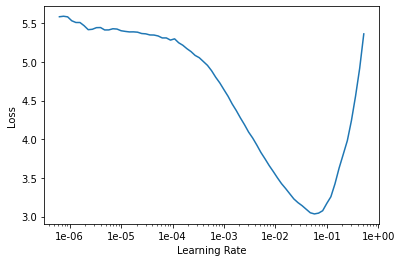

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.738010,0.303071,0.099459,02:31
1,0.472063,0.256334,0.083897,02:29
2,0.438441,0.236405,0.082544,02:27
3,0.366352,0.220727,0.072395,02:31
4,0.247845,0.202145,0.058187,02:31
5,0.178860,0.190840,0.058187,02:29
6,0.126484,0.173244,0.049391,02:30
7,0.111999,0.170495,0.054127,02:30


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [10]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.117707,0.165283,0.050068,02:42
1,0.108295,0.156584,0.046008,02:42
2,0.072453,0.159393,0.050068,02:42


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

## Export model and upload to S3

Now that we have trained our model we need to export it, create a tarball of the artefacts and upload to S3.


First we need to export the class names from the data object into a text file.

In [0]:
save_texts(path_img/'models/classes.txt', data.classes)

Now we need to export the model in the [PyTorch TorchScript format](https://pytorch.org/docs/stable/jit.html) so we can load into an AWS Lambda function.

In [0]:
trace_input = torch.ones(1,3,img_size,img_size).cuda()
jit_model = torch.jit.trace(learn.model.float(), trace_input)
model_file='resnet50_jit.pth'
output_path = str(path_img/f'models/{model_file}')
torch.jit.save(jit_model, output_path)

Next step is to create a tarfile of the exported classes file and model weights.

In [0]:
tar_file=path_img/'models/model.tar.gz'
classes_file='classes.txt'

In [0]:
with tarfile.open(tar_file, 'w:gz') as f:
    f.add(path_img/f'models/{model_file}', arcname=model_file)
    f.add(path_img/f'models/{classes_file}', arcname=classes_file)

Now we need to upload the model tarball to S3.

In [15]:
s3 = boto3.resource('s3')
s3.meta.client.upload_file(str(tar_file), 'REPLACE_WITH_YOUR_BUCKET_NAME', 'fastai-models/lesson1/model.tar.gz')

NoCredentialsError: ignored